In [16]:
import socket
import numpy as np
import pandas as pd
import time
import pika
import json

connection = pika.BlockingConnection(pika.ConnectionParameters(host='localhost'))
channel = connection.channel()
channel.queue_declare(queue='hello')

UDP_IP = "192.168.1.14"
UDP_PORT = 5555
CHUNKSIZE=1500
sock = socket.socket(socket.AF_INET, # Internet
                    socket.SOCK_DGRAM) # UDP

sock.bind((UDP_IP, UDP_PORT))

def divide_chunks(l, n):    
    # looping til length l
    for i in range(0, len(l), n):
        yield l[i:i + n] #How many elements each list should have

def chunk_to_df(total, msgpack=False):
    received = "".join(total).split(",")[1:]
    chunks = list(divide_chunks(received, 4))
    measurements = np.vstack(chunks)
    df = pd.DataFrame(measurements, columns=["sensor", "x", "y", "z"])
    if msgpack:
        df = df.to_msgpack()
    return df

def prep_df(df):
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    if df.shape[0]>CHUNKSIZE:
        df = df.iloc[:CHUNKSIZE]
    else:
        df = df.append(pd.DataFrame(index=range(CHUNKSIZE-len(df)), columns=df.columns), ignore_index=True)
        df.fillna(method="pad", inplace=True)
    return df.values

chunks = []
try:
    while True:
        reset = False
        print("Waiting for new stream.")
        while not reset:
            total = []
            reset_time = time.time()
            data, addr = sock.recvfrom(256) 
            if time.time()>reset_time+3:
                print("Stream reset")
                reset = True
        print("Starting stream in 3 seconds")
        time.sleep(3)
        print("Starting stream...")
        start = time.time()
        while time.time() < start+10:
            data, addr = sock.recvfrom(256) 
            total.append(data.decode("UTF-8"))
        print("Stream finished.")
        df = chunk_to_df(total, False)
        chunk = prep_df(df)
        chunks.append(chunk)
        #channel.basic_publish(exchange='', routing_key='hello', body=df)  

except KeyboardInterrupt:
    print("Closing connection.")
    sock.close()
    connection.close()

Waiting for stream.
Stream reset
Starting stream in 3 seconds
Stream finished.
Waiting for stream.
Stream reset
Starting stream in 3 seconds
Stream finished.
Waiting for stream.
Stream reset
Starting stream in 3 seconds
Stream finished.
Waiting for stream.
Stream reset
Starting stream in 3 seconds
Stream finished.
Waiting for stream.
Stream reset
Starting stream in 3 seconds
Stream finished.
Waiting for stream.
Stream reset
Starting stream in 3 seconds
Stream finished.
Waiting for stream.
Stream reset
Starting stream in 3 seconds
Stream finished.
Waiting for stream.
Stream reset
Starting stream in 3 seconds
Stream finished.
Waiting for stream.
Stream reset
Starting stream in 3 seconds
Stream finished.
Waiting for stream.
Stream reset
Starting stream in 3 seconds
Stream finished.
Waiting for stream.
Stream reset
Starting stream in 3 seconds
Stream finished.
Waiting for stream.
Stream reset
Starting stream in 3 seconds
Stream finished.
Waiting for stream.
Stream reset
Starting stream in 

ConnectionClosed: 

In [17]:
len(chunks)

13

In [18]:
for c in chunks:
    print(c.shape)

(1500, 4)
(1500, 4)
(1500, 4)
(1500, 4)
(1500, 4)
(1500, 4)
(1500, 4)
(1500, 4)
(1500, 4)
(1500, 4)
(1500, 4)
(1500, 4)
(1500, 4)


In [22]:
train = np.stack(chunks)

In [26]:
np.save(open("../data/train_1.npy", "wb"), train)

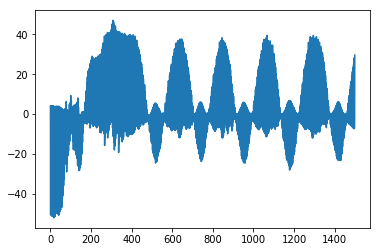

In [21]:
%matplotlib inline
pd.DataFrame(chunks[6], columns=df.columns).y.plot()